In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


## Data Inspection and EDA

In [2]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# Display the first few rows of the dataset
print(df.head())
print(df.describe())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [3]:
# Checking for missing values in each column
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


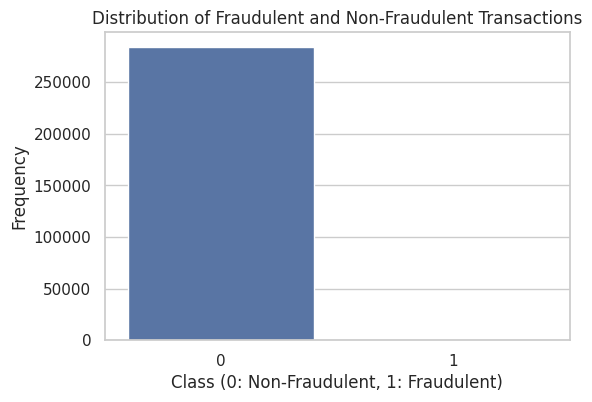

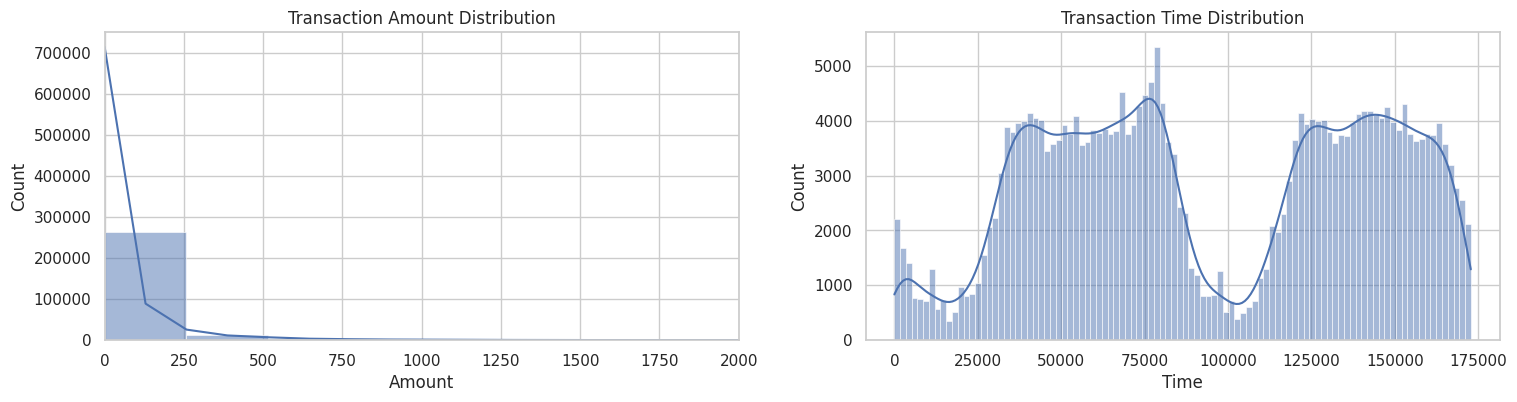

(0.1727485630620034, 492, 284315)

In [4]:
# Set the style of seaborn
sns.set(style="whitegrid")

# Distribution of the target variable 'Class'
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.xlabel('Class (0: Non-Fraudulent, 1: Fraudulent)')
plt.ylabel('Frequency')
plt.show()

# Transaction amount and time analysis
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(df['Amount'], bins=100, ax=ax[0], kde=True)
ax[0].set_title('Transaction Amount Distribution')
ax[0].set_xlim([0, 2000])  # Limiting to observe the distribution of smaller transactions

sns.histplot(df['Time'], bins=100, ax=ax[1], kde=True)
ax[1].set_title('Transaction Time Distribution')
plt.show()

# Checking for imbalance in the dataset
fraudulent_transactions = df[df['Class'] == 1]
non_fraudulent_transactions = df[df['Class'] == 0]

fraud_percentage = (len(fraudulent_transactions) / len(df)) * 100

fraud_percentage, len(fraudulent_transactions), len(non_fraudulent_transactions)

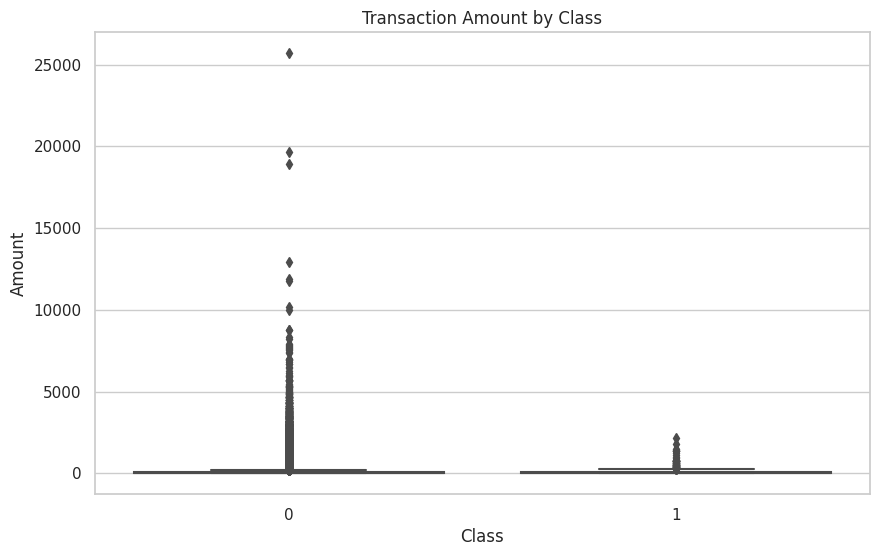

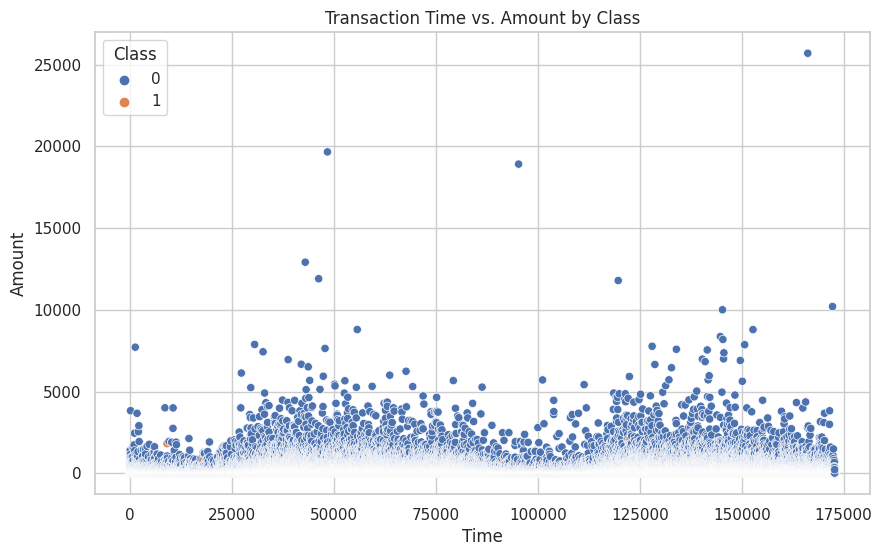

In [5]:
# Box plots for transaction amount by class to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Transaction Amount by Class')
plt.show()

# Scatter plot of Transaction Time vs. Amount to see if there is any pattern
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Time', y='Amount', hue='Class', data=df)
plt.title('Transaction Time vs. Amount by Class')
plt.show()


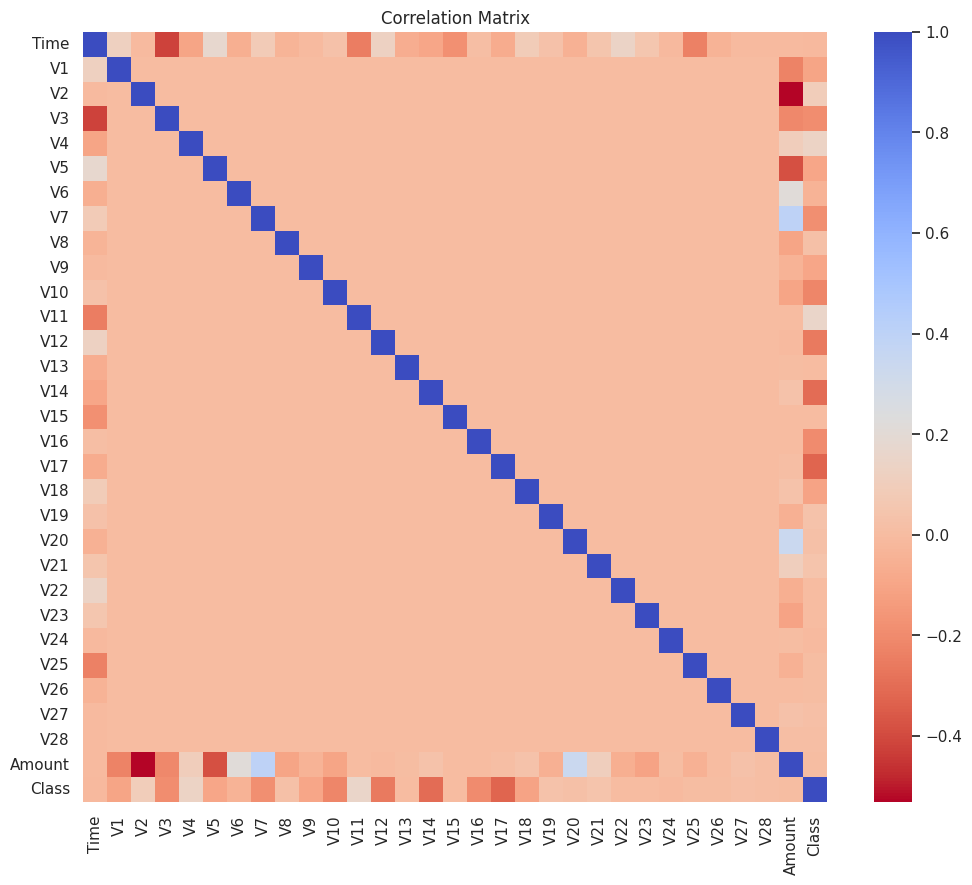

In [6]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.title('Correlation Matrix')
plt.show()

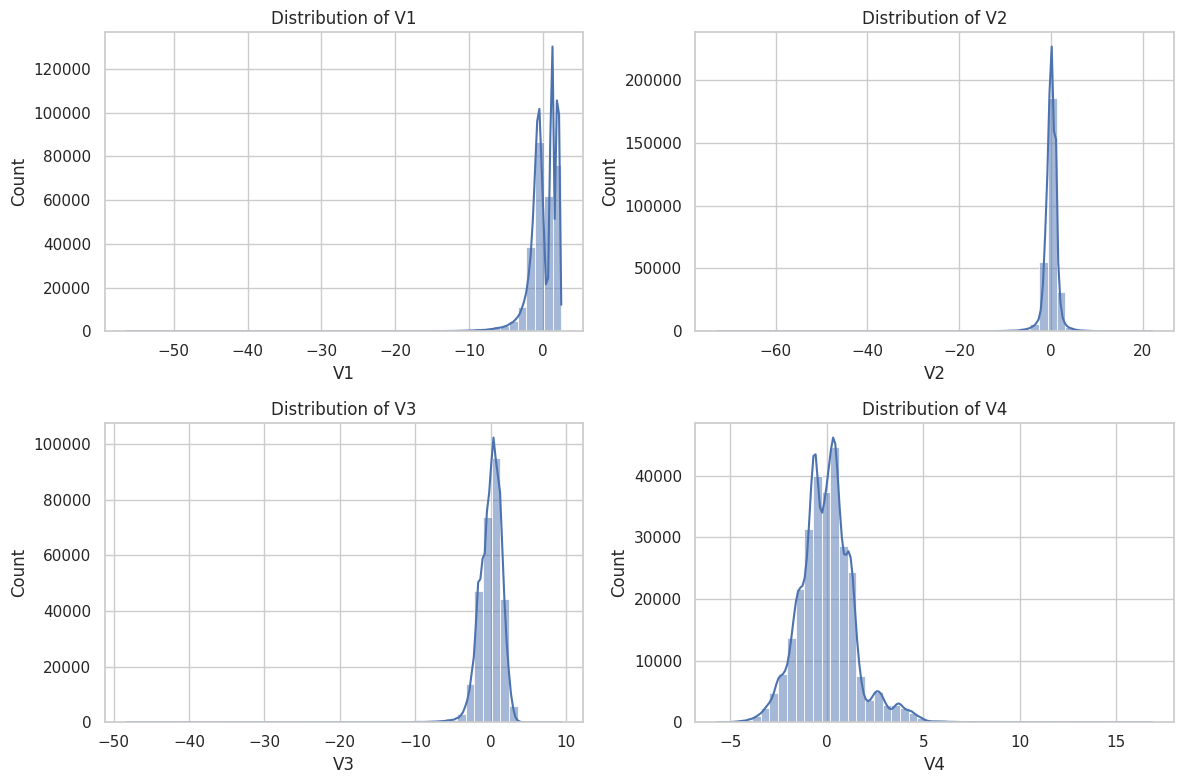

In [7]:
# Plotting distributions of some features
features = ['V1', 'V2', 'V3', 'V4']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[feature], kde=True, bins=50)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

## Scaling and Balacing Data

In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

#we scaled amount and time 

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [9]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Displaying the percentage of non-fraudulent and fraudulent transactions
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

# Preparing the features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Initializing StratifiedKFold for cross-validation
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Checking the distribution of labels in both training and testing datasets
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)
print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

# Convert to numpy arrays for compatibility with many scikit-learn models
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values 

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [10]:
# Randomly shuffle the original dataframe to ensure randomness
df_shuffled = df.sample(frac=1, random_state=42)

# Selecting all instances of the minority class (fraudulent transactions)
fraud_df = df_shuffled[df_shuffled['Class'] == 1]

# Randomly selecting an equal number of non-fraudulent transactions to match the number of fraudulent transactions
non_fraud_df = df_shuffled[df_shuffled['Class'] == 0].sample(n=len(fraud_df), random_state=42)

# Concatenating both datasets to form a new, balanced dataset
balanced_df = pd.concat([fraud_df, non_fraud_df])

# Shuffling the new dataframe to ensure that the order of data points doesn't hint at their class
balanced_df = balanced_df.sample(frac=1, random_state=42)

# Displaying the first few rows of the newly balanced dataset
balanced_df.head()


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
280412,-0.279466,0.996558,-0.300026,0.949818,0.074290,0.933936,0.996314,-0.734827,1.065931,-0.046607,...,0.004937,0.166577,0.660828,-0.253749,-0.004951,-0.059794,-0.392513,0.422035,0.234143,0
95597,18.615944,-0.226824,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,...,-0.447039,-0.511657,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,1
72197,2.586460,-0.353435,0.786116,-1.067510,0.917200,0.885069,-0.987685,0.989969,-0.692766,0.296164,...,0.365800,0.141353,0.412901,-0.432923,-0.366233,0.546041,0.702749,-0.008153,0.037743,0
75511,2.080905,-0.335930,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,...,0.270459,1.208054,0.277612,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,1
255556,-0.296653,0.852830,-0.242245,4.147186,-5.672349,6.493741,1.591168,-1.602523,-0.950463,0.722903,...,0.562030,0.249023,-0.480286,-0.286080,-1.153575,-0.035571,0.559628,0.409446,0.221048,1


Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


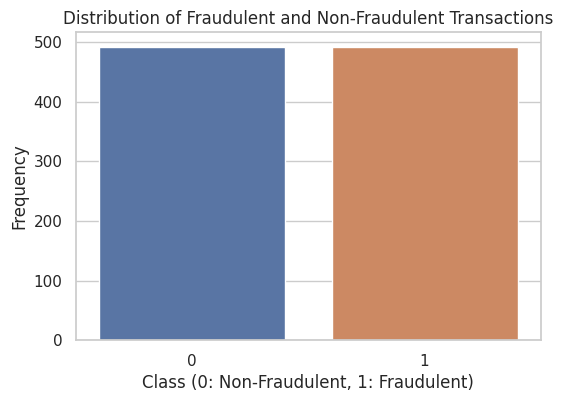

In [18]:
print('Distribution of the Classes in the subsample dataset')
print(balanced_df['Class'].value_counts()/len(balanced_df))

plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=balanced_df)
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.xlabel('Class (0: Non-Fraudulent, 1: Fraudulent)')
plt.ylabel('Frequency')
plt.show()

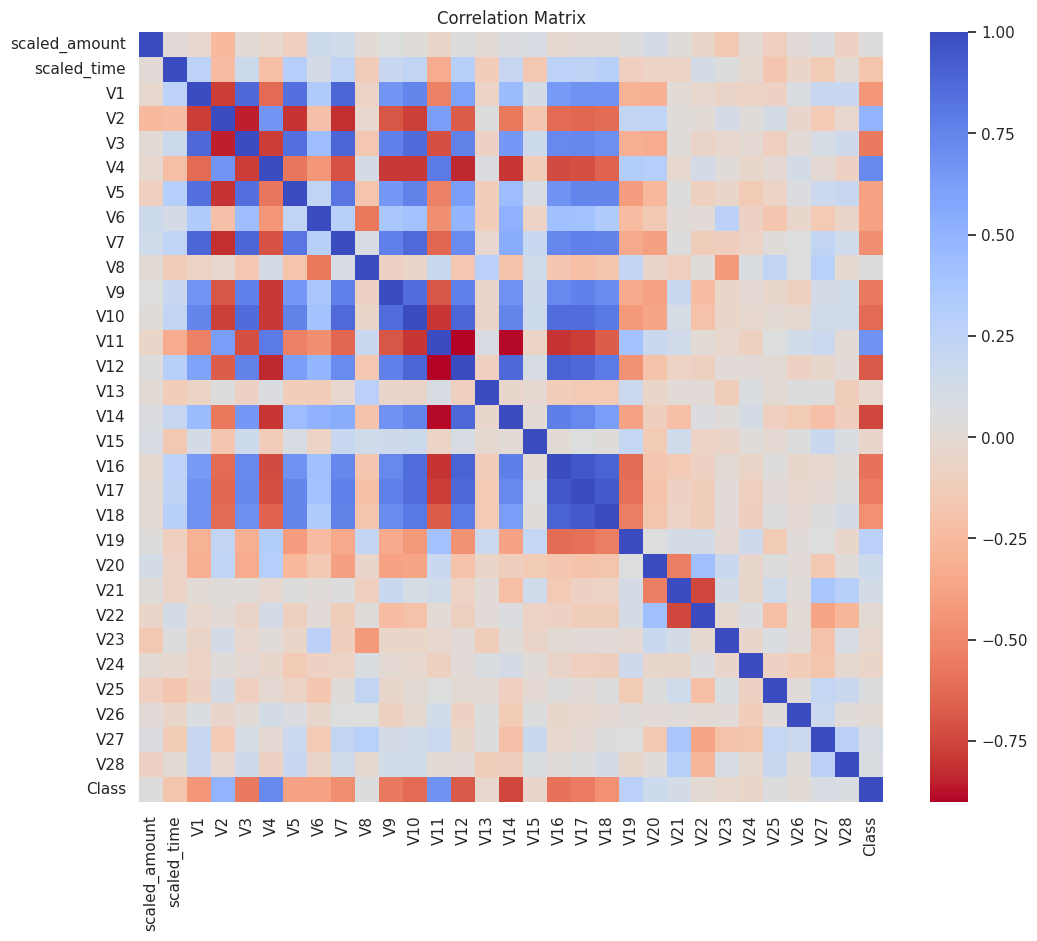

In [19]:
# Correlation matrix
corr = balanced_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.title('Correlation Matrix')
plt.show()

In [20]:
import numpy as np

# Function to remove outliers based on the IQR method
def remove_outliers(df, column):
    fraud_df = df[df['Class'] == 1][column]
    q25, q75 = np.percentile(fraud_df, 25), np.percentile(fraud_df, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = df[(df[column] > upper) | (df[column] < lower)]
    print(f'{column} Outliers for Fraud Cases: {len(outliers)}')
    print(f'{column} outliers: {outliers[column].values}')
    df = df.drop(outliers.index)
    return df

# Removing outliers for V14, V12, and V10 from the balanced dataset
balanced_df = remove_outliers(balanced_df, 'V14')
balanced_df = remove_outliers(balanced_df, 'V12')
balanced_df = remove_outliers(balanced_df, 'V10')

# After removing outliers, you might want to check the shape of the dataframe
print(f'Number of Instances after outlier removal: {balanced_df.shape[0]}')

V14 Outliers for Fraud Cases: 5
V14 outliers: [-19.21432549   4.96402029 -18.04999769 -18.49377336 -18.82208674]
V12 Outliers for Fraud Cases: 4
V12 outliers: [-18.68371463 -18.55369701 -18.04759657 -18.43113103]
V10 Outliers for Fraud Cases: 28
V10 outliers: [-15.56379134 -22.18708856 -24.40318497 -15.23996196 -16.30353766
 -15.56379134 -18.91324333 -15.12416281 -22.18708856 -16.64962816
 -22.18708856 -16.74604411 -16.60119697 -17.14151364 -18.27116817
 -16.25561175 -15.12375218 -15.34609885 -14.92465477 -15.23996196
   8.62794387 -22.18708856 -20.94919155 -19.83614885 -15.23183337
 -24.58826244 -14.92465477 -23.22825484]
Number of Instances after outlier removal: 947


## Dimensional Reduction and Clustering

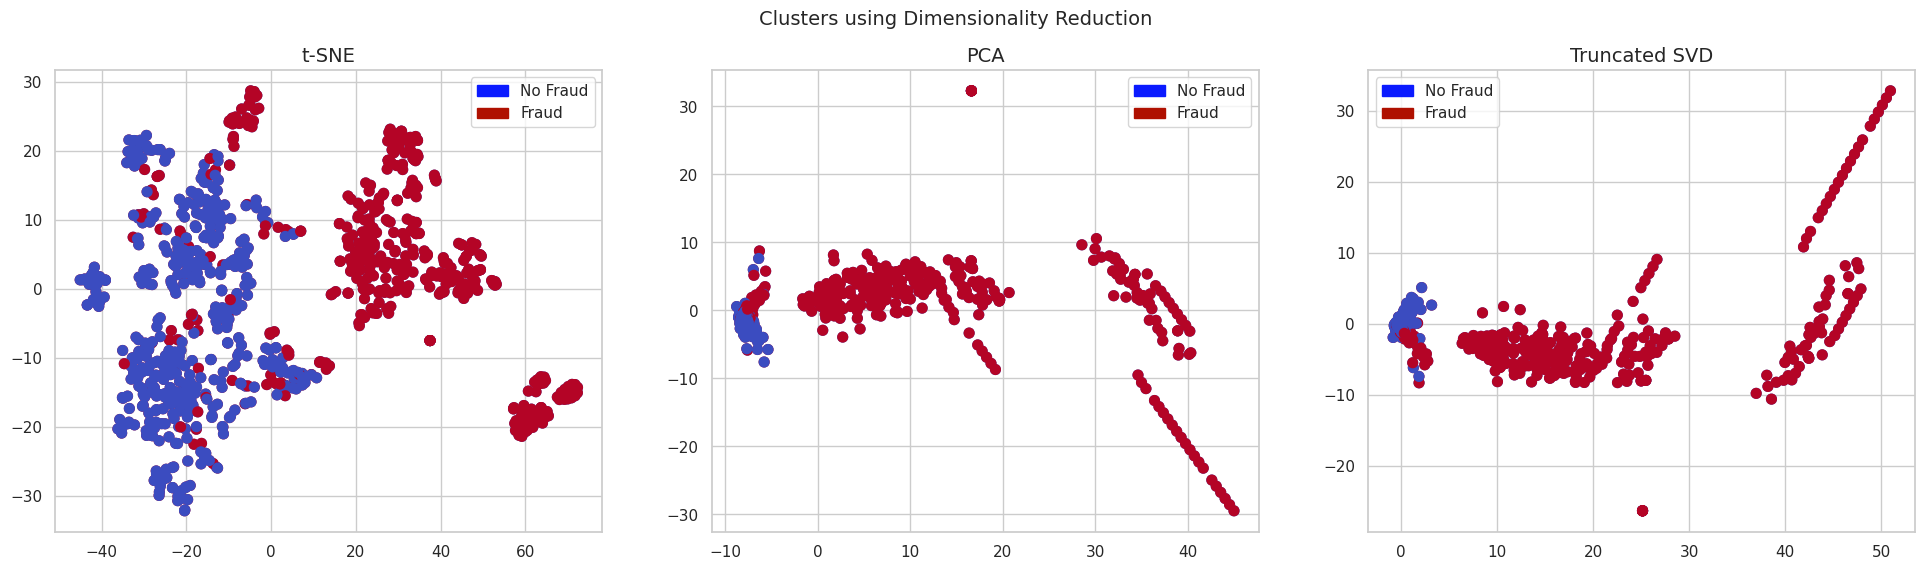

In [23]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

blue_patch = mpatches.Patch(color='#0A1AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF1000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

## Modeling 

In [26]:
X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to numpy arrays for compatibility with scikit-learn
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Dictionary of classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

# Training and evaluating the classifiers using cross-validation
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(f"Classifier: {classifier.__class__.__name__} has a training score of {round(training_score.mean(), 2) * 100}% accuracy.")

Classifier: LogisticRegression has a training score of 94.0% accuracy.
Classifier: KNeighborsClassifier has a training score of 93.0% accuracy.
Classifier: SVC has a training score of 93.0% accuracy.
Classifier: DecisionTreeClassifier has a training score of 91.0% accuracy.


## Parameter Tuning 

In [30]:
# Overfitting
from sklearn.model_selection import GridSearchCV

# Logistic Regression hyperparameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear']}

# GridSearchCV for Logistic Regression
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, cv=5)
grid_log_reg.fit(X_train, y_train)
# Best Logistic Regression estimator
log_reg = grid_log_reg.best_estimator_

# K-Nearest Neighbors hyperparameters
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# GridSearchCV for K-Nearest Neighbors
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params, cv=5)
grid_knears.fit(X_train, y_train)
# Best K-Nearest Neighbors estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier hyperparameters
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

# GridSearchCV for Support Vector Classifier
grid_svc = GridSearchCV(SVC(), svc_params, cv=5)
grid_svc.fit(X_train, y_train)
# Best Support Vector Classifier estimator
svc = grid_svc.best_estimator_

# Decision Tree Classifier hyperparameters
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), "min_samples_leaf": list(range(5,7,1))}

# GridSearchCV for Decision Tree Classifier
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5)
grid_tree.fit(X_train, y_train)
# Best Decision Tree estimator
tree_clf = grid_tree.best_estimator_

# Printing best estimators
print(f'Best Logistic Regression: {log_reg}')
print(f'Best K-Nearest Neighbors: {knears_neighbors}')
print(f'Best Support Vector Classifier: {svc}')
print(f'Best Decision Tree: {tree_clf}')


log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Best Logistic Regression: LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
Best K-Nearest Neighbors: KNeighborsClassifier(n_neighbors=4)
Best Support Vector Classifier: SVC(C=0.5, kernel='linear')
Best Decision Tree: DecisionTreeClassifier(max_depth=3, min_samples_leaf=6)
Logistic Regression Cross Validation Score:  93.79%
Knears Neighbors Cross Validation Score 92.73%
Support Vector Classifier Cross Validation Score 93.92%
DecisionTree Classifier Cross Validation Score 93.13%


## Undersampling 

In [34]:
#undersample 

undersample_X = balanced_df.drop('Class', axis=1)
undersample_y = balanced_df['Class']

# Defining the StratifiedKFold
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# Lists to keep track of model performance metrics
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique and evaluating models using cross-validation
for train_index, test_index in sss.split(undersample_X, undersample_y):
    # NearMiss happens during Cross Validation not before
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), LogisticRegression())
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
    undersample_model = undersample_pipeline.fit(undersample_Xtrain, undersample_ytrain)
    undersample_prediction = undersample_model.predict(undersample_Xtest)
    
    undersample_accuracy.append(accuracy_score(undersample_ytest, undersample_prediction))
    undersample_precision.append(precision_score(undersample_ytest, undersample_prediction))
    undersample_recall.append(recall_score(undersample_ytest, undersample_prediction))
    undersample_f1.append(f1_score(undersample_ytest, undersample_prediction))
    undersample_auc.append(roc_auc_score(undersample_ytest, undersample_prediction))

# Using cross_val_predict to get the predictions
log_reg = LogisticRegression()
knears_neighbors = KNeighborsClassifier()
svc = SVC()
tree_clf = DecisionTreeClassifier()

log_reg_pred = cross_val_predict(log_reg, undersample_X, undersample_y, cv=5, method="decision_function")
knears_pred = cross_val_predict(knears_neighbors, undersample_X, undersample_y, cv=5)
svc_pred = cross_val_predict(svc, undersample_X, undersample_y, cv=5, method="decision_function")
tree_pred = cross_val_predict(tree_clf, undersample_X, undersample_y, cv=5)

# Calculate the roc_auc_score for each classifier
log_reg_auc = roc_auc_score(undersample_y, log_reg_pred)
knears_auc = roc_auc_score(undersample_y, knears_pred)
svc_auc = roc_auc_score(undersample_y, svc_pred)
tree_auc = roc_auc_score(undersample_y, tree_pred)

# Printing the performance metrics
print(f'Logistic Regression: Accuracy={np.mean(undersample_accuracy)}, Precision={np.mean(undersample_precision)}, Recall={np.mean(undersample_recall)}, F1={np.mean(undersample_f1)}, AUC={log_reg_auc}')
print(f'KNearest Neighbors: AUC={knears_auc}')
print(f'Support Vector Classifier: AUC={svc_auc}')
print(f'Decision Tree: AUC={tree_auc}')

Logistic Regression: Accuracy=0.9239598997493734, Precision=0.9239451857238039, Recall=0.9190157668418537, F1=0.9210349454861925, AUC=0.9773366677086589
KNearest Neighbors: AUC=0.9329031393739114
Support Vector Classifier: AUC=0.9812664671995712
Decision Tree: AUC=0.9049948644665743


In [49]:
X = balanced_df.drop('Class', axis=1)
y = balanced_df['Class']

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying SMOTE for the training set
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

# Training the SVM with SMOTE
svc_sm = SVC()
svc_sm.fit(X_sm, y_sm)

# Predictions with SVM on the original test set
y_pred_sm = svc_sm.predict(X_test)
oversample_score = accuracy_score(y_test, y_pred_sm)

# SVM with Random UnderSampling for comparison (we use the test set from the original split)
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Creating a DataFrame with the scores
final_df = pd.DataFrame({
    'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'],
    'Score': [undersample_score, oversample_score]
})

# Displaying the final DataFrame
final_df

,Technique,Score
0,Random UnderSampling,0.942105
1,Oversampling (SMOTE),0.947368


## Conclusion 

Our machine learning models, particularly the Support Vector Machine (SVM) with SMOTE for oversampling, significantly improved the detection of fraudulent transactions, demonstrating the effectiveness of our approach in addressing the class imbalance problem.

This project not only enhances the accuracy of fraud detection but also minimizes false positives, thereby potentially saving millions in fraudulent transactions and increasing consumer trust in credit card usage.
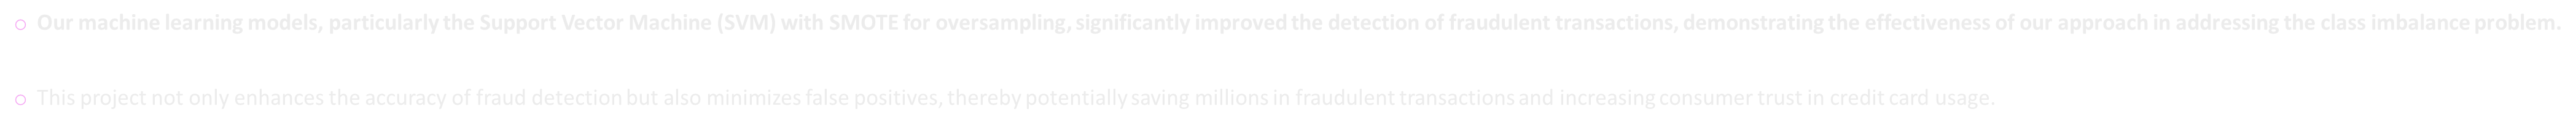
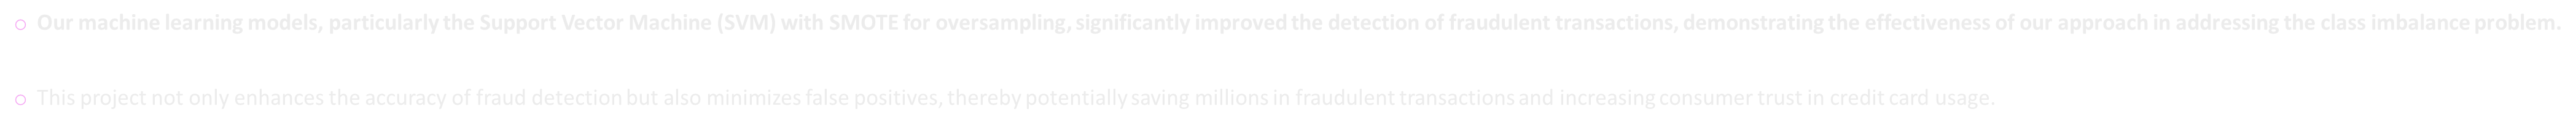
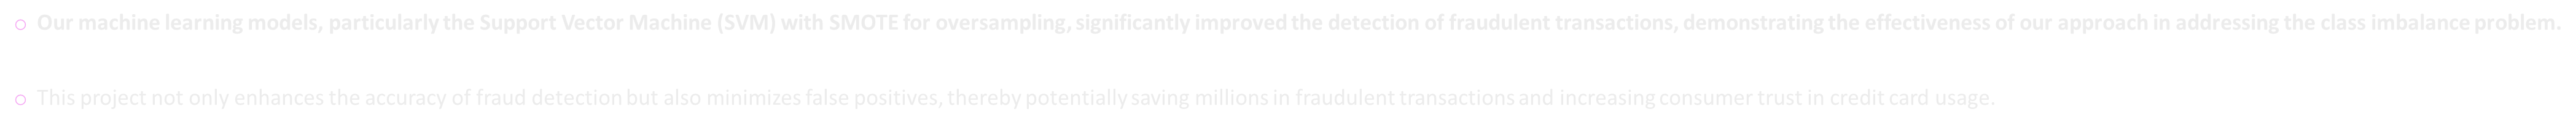
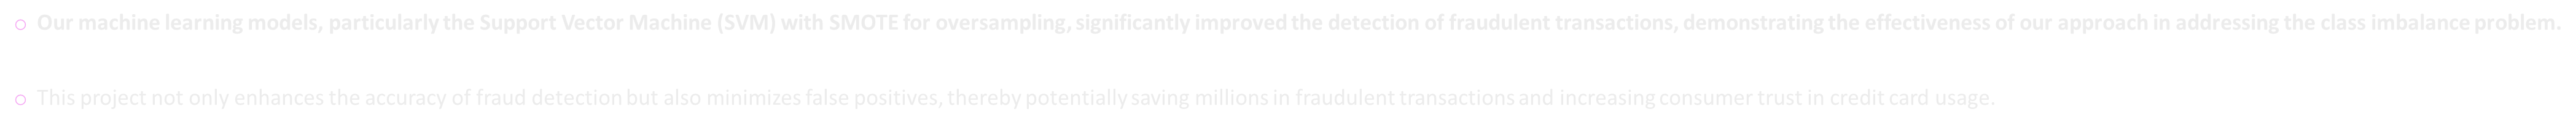